In [1]:
# Needed on Google Colab
import os
if os.environ.get('COLAB_GPU', False):
    !pip install -U transformers
    from google.colab import drive
    drive.mount("/content/drive")

     |████████████████████████████████| 2.1MB 6.8MB/s 
     |████████████████████████████████| 901kB 37.9MB/s 
     |████████████████████████████████| 3.3MB 56.7MB/s 
Mounted at /content/drive


In [2]:
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.4.1


Executing this on Colab will make sure that our model runs on a TPU if available and falls back to GPU / CPU otherwise:

In [3]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.88.20.58:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.88.20.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.88.20.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [4]:
# store current path and download and extract data there
CURR_PATH = !pwd

In [5]:
# PARAMETERS
PATH_DATA = CURR_PATH[0]
PATH_GDRIVE_TMP = "/content/drive/MyDrive/tmp/"  # Google Drive

In [6]:
# read data from csv
data = pd.read_csv(PATH_GDRIVE_TMP + "only_lockdown.csv", sep='\t', header=None, skiprows=[0])

# Create binary grade, class 1-2 or 5-6  = good or bad
data["opinion_integer"] = 0
data.loc[data[6] == '-', "opinion_integer"] = 0
data.loc[data[6] == 'o', "opinion_integer"] = 1
data.loc[data[6] == '+', "opinion_integer"] = 2

data.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,opinion_integer
0,-,x,x,x,-,-,-,29137,2020_03_15,16,NEOS,Abgeordneter Josef Schellhorn (NEOS),False,"Das heißt, diese Planbarkeit ist jetzt gar nicht machbar – für Sie nicht –, nur die Unternehmer kommen mit dieser Unplanbarkeit gar nicht zurecht, weil dieser Lockdown ja jetzt nur für eine Woche bestimmt ist.",0
1,-,x,-,x,x,-,-,31054,2020_03_20,19,NEOS,"Abgeordnete Mag. Beate Meinl-Reisinger, MES (NEOS)",False,"Wie und wann schaffen wir es, aus diesem Lockdown wieder herauszukommen, ohne die Gesundheit der Menschen in Österreich oder auch europaweit aufs Spiel zu setzen?",0
2,-,#,#+,-,x,-,-,32973,2020_04_03,22,ÖVP,Abgeordneter August Wöginger (ÖVP),True,"Kickl hat am 13. März von einem Lockdown gesprochen – also alles zudrehen, nichts geht mehr in diesem Land.",0
3,+,x,+,x,x,+,+,34265,2020_04_03,22,NEOS,Abgeordnete Dipl.-Ing. Karin Doppelbauer (NEOS),False,"Ich möchte gleich zu Beginn eines klarstellen, damit es keine Missverständnisse gibt: Ja, der Lockdown war richtig.",2
4,+,x,x,x,o,o,-,34269,2020_04_03,22,NEOS,Abgeordnete Dipl.-Ing. Karin Doppelbauer (NEOS),False,"Lassen Sie mich aber mit dem Gemeinsamen beginnen: Was das Ziel betrifft, sind wir uns ja alle einig: Es geht um nichts Geringeres als das Einpendeln unserer Volks­wirtschaft auf ein Level, wie es vor der Krise war, oder, wenn Sie so wollen, wenn man jetzt den Lockdown schrittweise lockert, dass dann das Wirtschaftssystem eigentlich genauso aussieht, wie es vor der Krise war.",0
5,+,x,x,x,+s,o,o,34709,2020_04_03,22,NEOS,Abgeordnete Mag. Martina Künsberg Sarre (NEOS),False,"Regelmäßige begleitende Datenerhe­bun­gen in dieser Phase des Lockdowns, in der Lehrer_innen, Schüler_innen und Eltern auf digitales Unterrichten und Lernen absolut angewiesen sind, können einen wesent­lichen Beitrag für eine effiziente Digitalisierung des Bildungssystems in der Zukunft leisten.",1


In [7]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
%%time
# Clean Comments
data["comment_clean"] = data.loc[data[13].str.len() > 20, 13]
data["comment_clean"] = data["comment_clean"].map(
    lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x
)

CPU times: user 152 ms, sys: 2.53 ms, total: 154 ms
Wall time: 170 ms


In [9]:
# Drop Missing
data = data.dropna(axis="index", subset=["opinion_integer", "comment_clean"]).reset_index(
    drop=True
)
data = data[["comment_clean", "opinion_integer"]]
data.columns = ["text", "label"]
data.head(2)
data.to_csv(PATH_GDRIVE_TMP + "only_lockdown_pp.csv", index=False)

In [10]:
def split_df(df, split_number):
    return df[:split_number], df[split_number:]

def corpus_split(holdback_per_class):
    train = pd.DataFrame()
    test = pd.DataFrame()

    for i in range(3):
        rows_with_class = data[data['label'] == i]
        rows_with_class = rows_with_class.sample(frac=1).reset_index(drop=True)
        l, r = split_df(rows_with_class, holdback_per_class)
        train = train.append(r, ignore_index=True)
        test = test.append(l, ignore_index=True)

    train = train.sample(frac=1).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)

    train_x = train['pp_text'].tolist()
    test_x = test['pp_text'].tolist()
    train_y = train['label'].tolist()
    test_y = test['label'].tolist()

    return train_x, test_x, train_y, test_y

In [11]:
# skip pre processing if done before
#data = pd.read_csv(PATH_GDRIVE_TMP + "only_lockdown_pp.csv")

In [12]:
# this will download and initialize the pre trained tokenizer
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

In [13]:
MAXLEN = 128
#MAXLEN = 256

def preprocess_text(data):
    """ take texts and prepare as input features for BERT 
    """
    input_ids = []
    # For every sentence...
    for comment in data:
        encoded_sent = tokenizer.encode_plus(
            text=comment,
            add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
            max_length=MAXLEN,  # Max length to truncate/pad
            pad_to_max_length=True,  # Pad sentence to max length
            return_attention_mask=False,  # attention mask not needed for our task
        )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get("input_ids"))
    return input_ids

In [14]:
%%time
import pickle

input_ids = preprocess_text(data["text"])
# tokenization takes quite long
# we can save the result and load it quickly via pickle
pickle.dump(input_ids, open(PATH_GDRIVE_TMP + "input_ids_lockdown.pkl", "wb"))
# input_ids = pickle.load(open(PATH_GDRIVE_TMP+"/input_ids.pkl", "rb"))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


CPU times: user 436 ms, sys: 0 ns, total: 436 ms
Wall time: 610 ms


# Here Begins the Repeatable Code

In [15]:
# Set Model Parameters
MAXLEN = MAXLEN
BATCH_SIZE_PER_REPLICA = 8
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCHS = 20
LEARNING_RATE = 1e-5
DATA_LENGTH = len(data)

In [16]:
# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=EPOCHS, restore_best_weights=True
    ),
    # tf.keras.callbacks.ModelCheckpoint(
    #    PATH_GDRIVE_TMP + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
    #    monitor="val_loss",
    #    save_best_only=True,
    #    verbose=1,
    # ),
]

In [17]:
def build_model(transformer, max_len=MAXLEN):
    """ add binary classification to pretrained model
    """
    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = tf.keras.layers.Dense(3, activation="sigmoid")(cls_token)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=out)
    model.compile(
        tf.keras.optimizers.Adam(lr=LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [18]:
def create_dataset(
    data_tuple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    buffer_size=DATA_LENGTH,
    train=False,
):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(
            buffer_size=buffer_size, reshuffle_each_iteration=True
        ).repeat(epochs)
    dataset = dataset.batch(batch_size)
    return dataset

In [19]:
from collections import Counter

In [20]:
data['pp_text'] = preprocess_text(data['text'])

In [21]:
train_ids, test_ids, train_labels, test_labels = corpus_split(20)

In [22]:
runs = 500
accuracies = []
for i in range(runs):
  train_ids, test_ids, train_labels, test_labels = corpus_split(20)
  train = create_dataset((train_ids, train_labels), buffer_size=len(train_ids), train=True)
  test = create_dataset((test_ids, test_labels), buffer_size=len(test_ids))
  with strategy.scope():
    transformer_layers = TFBertModel.from_pretrained("bert-base-german-cased")
    model = build_model(transformer_layers, max_len=MAXLEN)
  train_counts = Counter(train_labels)
  num_in_largest_class = max(train_counts.values())
  class_weights = {k: num_in_largest_class / train_counts[k] for k in train_counts.keys()}

  # Train using appropriate steps per epochs (go through all train data in an epoch)
  steps_per_epoch = int(np.floor((len(train_ids) / BATCH_SIZE)))
  hist = model.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=test,
    verbose=1,
    class_weight = class_weights,
    callbacks=callbacks,
  )

  # Evaluate
  pred = model.predict(test, batch_size=BATCH_SIZE, verbose=2, use_multiprocessing=True)
  pred_class = np.argmax(pred, axis=-1)
  report = metrics.classification_report(test_labels, pred_class, output_dict=True)
  acc = report['accuracy']
  accuracies.append(acc)
  with open(PATH_GDRIVE_TMP + 'bert_4_accuracies.txt', 'a+') as f:
    f.write("%s\n" % acc)

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5268 - accuracy: 0.2729WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 82s 2s/step - loss: 2.5166 - accuracy: 0.2711 - val_loss: 1.2928 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 247ms/step - loss: 2.1311 - accuracy: 0.2787 - val_loss: 1.0694 - val_accuracy: 0.4333
Epoch 3/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9350 - accuracy: 0.4352 - val_loss: 1.1083 - val_accuracy: 0.4500
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9298 - accuracy: 0.2882 - val_loss: 1.0700 - val_accuracy: 0.4000
Epoch 5/20
6/6 [==============================] - 1s 242ms/step - loss: 1.8233 - accuracy: 0.4964 - val_loss: 1.0666 - val_accuracy: 0.4333
Epoch 6/20
6/6 [==============================] - 2s 347ms/step - loss: 1.8553 - accuracy: 0.3833 - val_loss: 1.0751 - val_accuracy: 0.3667
Epoch 7/20
6/6 [==============================] - 1s 249ms/step - loss: 1.8293 - accuracy: 0.5135 - val_loss: 1.1193 - val_accuracy: 0.4167
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.7534 - accuracy: 0.3635WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 82s 2s/step - loss: 2.7226 - accuracy: 0.3658 - val_loss: 1.2771 - val_accuracy: 0.4667
Epoch 2/20
6/6 [==============================] - 1s 240ms/step - loss: 2.1881 - accuracy: 0.2887 - val_loss: 1.1011 - val_accuracy: 0.3667
Epoch 3/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8949 - accuracy: 0.3459 - val_loss: 1.0891 - val_accuracy: 0.3667
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8590 - accuracy: 0.4463 - val_loss: 1.0886 - val_accuracy: 0.3833
Epoch 5/20
6/6 [==============================] - 1s 242ms/step - loss: 1.8367 - accuracy: 0.3254 - val_loss: 1.0964 - val_accuracy: 0.4167
Epoch 6/20
6/6 [==============================] - 1s 242ms/step - loss: 1.7754 - accuracy: 0.5046 - val_loss: 1.0903 - val_accuracy: 0.4333
Epoch 7/20
6/6 [==============================] - 1s 241ms/step - loss: 1.7295 - accuracy: 0.4809 - val_loss: 1.1255 - val_accuracy: 0.3667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 3.2938 - accuracy: 0.2994WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 84s 2s/step - loss: 3.2124 - accuracy: 0.3125 - val_loss: 1.2469 - val_accuracy: 0.3167
Epoch 2/20
6/6 [==============================] - 1s 240ms/step - loss: 2.1276 - accuracy: 0.2566 - val_loss: 1.2606 - val_accuracy: 0.3500
Epoch 3/20
6/6 [==============================] - 1s 242ms/step - loss: 1.8555 - accuracy: 0.4954 - val_loss: 1.2115 - val_accuracy: 0.3333
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 2.0112 - accuracy: 0.2463 - val_loss: 1.2053 - val_accuracy: 0.3333
Epoch 5/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8941 - accuracy: 0.5066 - val_loss: 1.1467 - val_accuracy: 0.3833
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9013 - accuracy: 0.2467 - val_loss: 1.1630 - val_accuracy: 0.3833
Epoch 7/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9042 - accuracy: 0.4837 - val_loss: 1.1182 - val_accuracy: 0.4167
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.8117 - accuracy: 0.3752WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 85s 2s/step - loss: 2.7801 - accuracy: 0.3696 - val_loss: 1.3403 - val_accuracy: 0.3167
Epoch 2/20
6/6 [==============================] - 2s 386ms/step - loss: 2.1688 - accuracy: 0.4870 - val_loss: 1.3068 - val_accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 1s 245ms/step - loss: 2.0013 - accuracy: 0.3280 - val_loss: 1.1317 - val_accuracy: 0.3667
Epoch 4/20
6/6 [==============================] - 1s 243ms/step - loss: 1.9735 - accuracy: 0.4838 - val_loss: 1.1112 - val_accuracy: 0.4500
Epoch 5/20
6/6 [==============================] - 1s 243ms/step - loss: 1.8565 - accuracy: 0.3621 - val_loss: 1.0829 - val_accuracy: 0.4333
Epoch 6/20
6/6 [==============================] - 1s 241ms/step - loss: 1.7106 - accuracy: 0.6159 - val_loss: 1.0924 - val_accuracy: 0.4667
Epoch 7/20
6/6 [==============================] - 1s 242ms/step - loss: 1.6195 - accuracy: 0.5115 - val_loss: 1.0630 - val_accuracy: 0.4167
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5741 - accuracy: 0.3994WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.5686 - accuracy: 0.4012 - val_loss: 1.1108 - val_accuracy: 0.4167
Epoch 2/20
6/6 [==============================] - 1s 243ms/step - loss: 2.1569 - accuracy: 0.2583 - val_loss: 1.0983 - val_accuracy: 0.4333
Epoch 3/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9279 - accuracy: 0.4893 - val_loss: 1.0951 - val_accuracy: 0.4333
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9644 - accuracy: 0.3823 - val_loss: 1.1091 - val_accuracy: 0.4000
Epoch 5/20
6/6 [==============================] - 1s 243ms/step - loss: 1.8501 - accuracy: 0.3552 - val_loss: 1.0815 - val_accuracy: 0.4500
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.7996 - accuracy: 0.5357 - val_loss: 1.0970 - val_accuracy: 0.4333
Epoch 7/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7069 - accuracy: 0.4252 - val_loss: 1.0459 - val_accuracy: 0.4167
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6376 - accuracy: 0.2941WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 86s 2s/step - loss: 2.6125 - accuracy: 0.2927 - val_loss: 1.0912 - val_accuracy: 0.3833
Epoch 2/20
6/6 [==============================] - 1s 244ms/step - loss: 2.1030 - accuracy: 0.3263 - val_loss: 1.0712 - val_accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 1s 243ms/step - loss: 1.8733 - accuracy: 0.4572 - val_loss: 1.0612 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9850 - accuracy: 0.4367 - val_loss: 1.0838 - val_accuracy: 0.4500
Epoch 5/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8899 - accuracy: 0.5469 - val_loss: 1.1433 - val_accuracy: 0.4500
Epoch 6/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7622 - accuracy: 0.4193 - val_loss: 1.1291 - val_accuracy: 0.3667
Epoch 7/20
6/6 [==============================] - 1s 243ms/step - loss: 1.7594 - accuracy: 0.5763 - val_loss: 1.0979 - val_accuracy: 0.4500
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6135 - accuracy: 0.3776WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 86s 2s/step - loss: 2.5898 - accuracy: 0.3769 - val_loss: 1.1374 - val_accuracy: 0.3833
Epoch 2/20
6/6 [==============================] - 1s 242ms/step - loss: 1.9781 - accuracy: 0.4028 - val_loss: 1.0739 - val_accuracy: 0.4667
Epoch 3/20
6/6 [==============================] - 1s 243ms/step - loss: 1.9956 - accuracy: 0.3749 - val_loss: 1.2005 - val_accuracy: 0.3333
Epoch 4/20
6/6 [==============================] - 1s 243ms/step - loss: 2.0817 - accuracy: 0.2372 - val_loss: 1.1216 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 1s 245ms/step - loss: 2.1457 - accuracy: 0.3990 - val_loss: 1.0712 - val_accuracy: 0.4667
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8241 - accuracy: 0.3439 - val_loss: 1.0426 - val_accuracy: 0.5167
Epoch 7/20
6/6 [==============================] - 1s 248ms/step - loss: 1.7132 - accuracy: 0.5707 - val_loss: 1.0190 - val_accuracy: 0.5167
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.2233 - accuracy: 0.3438WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.2207 - accuracy: 0.3404 - val_loss: 1.1580 - val_accuracy: 0.3667
Epoch 2/20
6/6 [==============================] - 1s 243ms/step - loss: 2.0481 - accuracy: 0.3677 - val_loss: 1.0958 - val_accuracy: 0.4000
Epoch 3/20
6/6 [==============================] - 1s 243ms/step - loss: 1.9623 - accuracy: 0.3433 - val_loss: 1.0931 - val_accuracy: 0.4167
Epoch 4/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8246 - accuracy: 0.4529 - val_loss: 1.0650 - val_accuracy: 0.4500
Epoch 5/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7788 - accuracy: 0.4123 - val_loss: 1.0941 - val_accuracy: 0.4167
Epoch 6/20
6/6 [==============================] - 1s 245ms/step - loss: 1.7800 - accuracy: 0.5641 - val_loss: 1.0702 - val_accuracy: 0.4333
Epoch 7/20
6/6 [==============================] - 1s 246ms/step - loss: 1.6355 - accuracy: 0.5232 - val_loss: 1.0663 - val_accuracy: 0.4667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.4286 - accuracy: 0.2916WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.4236 - accuracy: 0.2913 - val_loss: 1.2065 - val_accuracy: 0.3667
Epoch 2/20
6/6 [==============================] - 1s 249ms/step - loss: 1.9187 - accuracy: 0.3321 - val_loss: 1.1629 - val_accuracy: 0.3667
Epoch 3/20
6/6 [==============================] - 1s 249ms/step - loss: 2.0194 - accuracy: 0.4054 - val_loss: 1.1377 - val_accuracy: 0.3000
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9264 - accuracy: 0.3462 - val_loss: 1.1218 - val_accuracy: 0.3500
Epoch 5/20
6/6 [==============================] - 1s 247ms/step - loss: 1.7876 - accuracy: 0.4118 - val_loss: 1.0952 - val_accuracy: 0.3667
Epoch 6/20
6/6 [==============================] - 1s 251ms/step - loss: 1.7665 - accuracy: 0.4959 - val_loss: 1.1402 - val_accuracy: 0.3833
Epoch 7/20
6/6 [==============================] - 1s 249ms/step - loss: 1.7201 - accuracy: 0.4753 - val_loss: 1.1116 - val_accuracy: 0.3667
Epoch 8/20
6/6 [=================

1/1 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.1667 - accuracy: 0.3992WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 85s 2s/step - loss: 2.1748 - accuracy: 0.4058 - val_loss: 1.2924 - val_accuracy: 0.3667
Epoch 2/20
6/6 [==============================] - 1s 248ms/step - loss: 2.2702 - accuracy: 0.2336 - val_loss: 1.1445 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 1s 247ms/step - loss: 2.0031 - accuracy: 0.5148 - val_loss: 1.0663 - val_accuracy: 0.4500
Epoch 4/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8397 - accuracy: 0.3382 - val_loss: 1.0764 - val_accuracy: 0.4333
Epoch 5/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8530 - accuracy: 0.4799 - val_loss: 1.0701 - val_accuracy: 0.3667
Epoch 6/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8184 - accuracy: 0.5193 - val_loss: 1.0708 - val_accuracy: 0.4500
Epoch 7/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7687 - accuracy: 0.4913 - val_loss: 1.0920 - val_accuracy: 0.4833
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.4912 - accuracy: 0.3483WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 85s 2s/step - loss: 2.4836 - accuracy: 0.3458 - val_loss: 1.2535 - val_accuracy: 0.3833
Epoch 2/20
6/6 [==============================] - 1s 240ms/step - loss: 2.1222 - accuracy: 0.3477 - val_loss: 1.1534 - val_accuracy: 0.2833
Epoch 3/20
6/6 [==============================] - 2s 408ms/step - loss: 2.0382 - accuracy: 0.3969 - val_loss: 1.1333 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 1s 243ms/step - loss: 1.9426 - accuracy: 0.2697 - val_loss: 1.1278 - val_accuracy: 0.2833
Epoch 5/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8866 - accuracy: 0.4589 - val_loss: 1.1462 - val_accuracy: 0.3667
Epoch 6/20
6/6 [==============================] - 1s 243ms/step - loss: 1.8588 - accuracy: 0.3547 - val_loss: 1.1047 - val_accuracy: 0.3500
Epoch 7/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8472 - accuracy: 0.3167 - val_loss: 1.0562 - val_accuracy: 0.4333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.8722 - accuracy: 0.3320WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 85s 2s/step - loss: 2.8332 - accuracy: 0.3371 - val_loss: 1.3166 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 245ms/step - loss: 2.1897 - accuracy: 0.3060 - val_loss: 1.1958 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9257 - accuracy: 0.4883 - val_loss: 1.1383 - val_accuracy: 0.3833
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9725 - accuracy: 0.3016 - val_loss: 1.1581 - val_accuracy: 0.3167
Epoch 5/20
6/6 [==============================] - 2s 428ms/step - loss: 1.8567 - accuracy: 0.4616 - val_loss: 1.1174 - val_accuracy: 0.3667
Epoch 6/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9293 - accuracy: 0.4034 - val_loss: 1.1195 - val_accuracy: 0.3333
Epoch 7/20
6/6 [==============================] - 1s 252ms/step - loss: 1.7224 - accuracy: 0.3942 - val_loss: 1.1772 - val_accuracy: 0.3833
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6708 - accuracy: 0.3050WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.6718 - accuracy: 0.3057 - val_loss: 1.3980 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 241ms/step - loss: 2.2034 - accuracy: 0.2112 - val_loss: 1.3083 - val_accuracy: 0.3000
Epoch 3/20
6/6 [==============================] - 1s 243ms/step - loss: 2.0501 - accuracy: 0.3950 - val_loss: 1.1883 - val_accuracy: 0.3333
Epoch 4/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8968 - accuracy: 0.2442 - val_loss: 1.2073 - val_accuracy: 0.3667
Epoch 5/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8788 - accuracy: 0.4949 - val_loss: 1.2243 - val_accuracy: 0.4167
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.7426 - accuracy: 0.3976 - val_loss: 1.2251 - val_accuracy: 0.3500
Epoch 7/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7428 - accuracy: 0.5571 - val_loss: 1.1896 - val_accuracy: 0.4000
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.4608 - accuracy: 0.3717WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.4512 - accuracy: 0.3703 - val_loss: 1.3186 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 248ms/step - loss: 2.2260 - accuracy: 0.2899 - val_loss: 1.1822 - val_accuracy: 0.3500
Epoch 3/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8637 - accuracy: 0.5020 - val_loss: 1.1513 - val_accuracy: 0.3667
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8679 - accuracy: 0.3016 - val_loss: 1.1719 - val_accuracy: 0.3667
Epoch 5/20
6/6 [==============================] - 1s 249ms/step - loss: 1.8786 - accuracy: 0.5526 - val_loss: 1.0710 - val_accuracy: 0.4333
Epoch 6/20
6/6 [==============================] - 1s 248ms/step - loss: 1.7516 - accuracy: 0.4564 - val_loss: 1.0569 - val_accuracy: 0.4500
Epoch 7/20
6/6 [==============================] - 1s 248ms/step - loss: 1.6308 - accuracy: 0.6022 - val_loss: 1.1383 - val_accuracy: 0.4000
Epoch 8/20
6/6 [=================

1/1 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5806 - accuracy: 0.2578WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 85s 2s/step - loss: 2.5460 - accuracy: 0.2638 - val_loss: 1.2551 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 242ms/step - loss: 1.9673 - accuracy: 0.3292 - val_loss: 1.3028 - val_accuracy: 0.3000
Epoch 3/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0913 - accuracy: 0.3057 - val_loss: 1.1946 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8761 - accuracy: 0.4968 - val_loss: 1.1998 - val_accuracy: 0.3667
Epoch 5/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9027 - accuracy: 0.4275 - val_loss: 1.1678 - val_accuracy: 0.4000
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8288 - accuracy: 0.4311 - val_loss: 1.1804 - val_accuracy: 0.4000
Epoch 7/20
6/6 [==============================] - 1s 244ms/step - loss: 1.6622 - accuracy: 0.5095 - val_loss: 1.1843 - val_accuracy: 0.3167
Epoch 8/20
6/6 [=================

1/1 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.7911 - accuracy: 0.2776WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 85s 2s/step - loss: 2.7376 - accuracy: 0.2819 - val_loss: 1.1838 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 240ms/step - loss: 2.0380 - accuracy: 0.3401 - val_loss: 1.2219 - val_accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 1s 242ms/step - loss: 1.9073 - accuracy: 0.4360 - val_loss: 1.1021 - val_accuracy: 0.3333
Epoch 4/20
6/6 [==============================] - 1s 239ms/step - loss: 1.8490 - accuracy: 0.3453 - val_loss: 1.0935 - val_accuracy: 0.3500
Epoch 5/20
6/6 [==============================] - 1s 243ms/step - loss: 1.8699 - accuracy: 0.5060 - val_loss: 1.1010 - val_accuracy: 0.3500
Epoch 6/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7589 - accuracy: 0.5068 - val_loss: 1.0887 - val_accuracy: 0.4167
Epoch 7/20
6/6 [==============================] - 1s 241ms/step - loss: 1.5331 - accuracy: 0.5924 - val_loss: 1.0829 - val_accuracy: 0.4000
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6583 - accuracy: 0.3439WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 86s 2s/step - loss: 2.6463 - accuracy: 0.3353 - val_loss: 1.1958 - val_accuracy: 0.3167
Epoch 2/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9393 - accuracy: 0.4639 - val_loss: 1.1450 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 1s 241ms/step - loss: 2.0348 - accuracy: 0.3113 - val_loss: 1.1413 - val_accuracy: 0.3167
Epoch 4/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8431 - accuracy: 0.3432 - val_loss: 1.1180 - val_accuracy: 0.3667
Epoch 5/20
6/6 [==============================] - 2s 416ms/step - loss: 1.9344 - accuracy: 0.4597 - val_loss: 1.0726 - val_accuracy: 0.4167
Epoch 6/20
6/6 [==============================] - 1s 245ms/step - loss: 1.7297 - accuracy: 0.4174 - val_loss: 1.0792 - val_accuracy: 0.4333
Epoch 7/20
6/6 [==============================] - 1s 245ms/step - loss: 1.7849 - accuracy: 0.5705 - val_loss: 1.0246 - val_accuracy: 0.4833
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6749 - accuracy: 0.3562WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 2.6536 - accuracy: 0.3578 - val_loss: 1.0915 - val_accuracy: 0.3167
Epoch 2/20
6/6 [==============================] - 1s 247ms/step - loss: 2.0227 - accuracy: 0.2604 - val_loss: 1.1084 - val_accuracy: 0.4000
Epoch 3/20
6/6 [==============================] - 1s 252ms/step - loss: 2.0917 - accuracy: 0.3595 - val_loss: 1.0790 - val_accuracy: 0.4333
Epoch 4/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9262 - accuracy: 0.3427 - val_loss: 1.0593 - val_accuracy: 0.4500
Epoch 5/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8238 - accuracy: 0.3800 - val_loss: 1.0848 - val_accuracy: 0.3833
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9371 - accuracy: 0.4746 - val_loss: 1.0894 - val_accuracy: 0.4167
Epoch 7/20
6/6 [==============================] - 1s 243ms/step - loss: 1.9273 - accuracy: 0.3627 - val_loss: 1.0938 - val_accuracy: 0.4333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 3.1935 - accuracy: 0.3613WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 3.1454 - accuracy: 0.3487 - val_loss: 1.4530 - val_accuracy: 0.3000
Epoch 2/20
6/6 [==============================] - 2s 416ms/step - loss: 2.4466 - accuracy: 0.5182 - val_loss: 1.1706 - val_accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 1s 247ms/step - loss: 2.0429 - accuracy: 0.2699 - val_loss: 1.1135 - val_accuracy: 0.4667
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8507 - accuracy: 0.4044 - val_loss: 1.1472 - val_accuracy: 0.3333
Epoch 5/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9740 - accuracy: 0.4818 - val_loss: 1.1171 - val_accuracy: 0.4333
Epoch 6/20
6/6 [==============================] - 1s 258ms/step - loss: 1.8428 - accuracy: 0.3225 - val_loss: 1.1508 - val_accuracy: 0.3500
Epoch 7/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9275 - accuracy: 0.5352 - val_loss: 1.1916 - val_accuracy: 0.4000
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.8467 - accuracy: 0.3665WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 84s 2s/step - loss: 2.8141 - accuracy: 0.3651 - val_loss: 1.2406 - val_accuracy: 0.3000
Epoch 2/20
6/6 [==============================] - 1s 245ms/step - loss: 2.1530 - accuracy: 0.3125 - val_loss: 1.0557 - val_accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8918 - accuracy: 0.4110 - val_loss: 1.0703 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 2s 424ms/step - loss: 1.9840 - accuracy: 0.3242 - val_loss: 1.0648 - val_accuracy: 0.3833
Epoch 5/20
6/6 [==============================] - 1s 254ms/step - loss: 1.8178 - accuracy: 0.5261 - val_loss: 1.1031 - val_accuracy: 0.3833
Epoch 6/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8059 - accuracy: 0.3846 - val_loss: 1.0639 - val_accuracy: 0.4667
Epoch 7/20
6/6 [==============================] - 1s 247ms/step - loss: 1.7207 - accuracy: 0.4930 - val_loss: 1.0809 - val_accuracy: 0.4333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5745 - accuracy: 0.2572WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.5812 - accuracy: 0.2580 - val_loss: 1.4963 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 243ms/step - loss: 2.5821 - accuracy: 0.2223 - val_loss: 1.2655 - val_accuracy: 0.3500
Epoch 3/20
6/6 [==============================] - 1s 246ms/step - loss: 2.0219 - accuracy: 0.3817 - val_loss: 1.1043 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9454 - accuracy: 0.4414 - val_loss: 1.0993 - val_accuracy: 0.4167
Epoch 5/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9358 - accuracy: 0.4157 - val_loss: 1.0721 - val_accuracy: 0.4500
Epoch 6/20
6/6 [==============================] - 1s 249ms/step - loss: 1.7643 - accuracy: 0.4818 - val_loss: 1.0721 - val_accuracy: 0.4333
Epoch 7/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8493 - accuracy: 0.4933 - val_loss: 1.1017 - val_accuracy: 0.4667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.4315 - accuracy: 0.3703WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.4179 - accuracy: 0.3781 - val_loss: 1.1432 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9165 - accuracy: 0.4149 - val_loss: 1.1241 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 1s 247ms/step - loss: 2.0022 - accuracy: 0.4275 - val_loss: 1.1069 - val_accuracy: 0.4167
Epoch 4/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7628 - accuracy: 0.2948 - val_loss: 1.0979 - val_accuracy: 0.4500
Epoch 5/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0481 - accuracy: 0.4786 - val_loss: 1.1498 - val_accuracy: 0.4500
Epoch 6/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8421 - accuracy: 0.3254 - val_loss: 1.1031 - val_accuracy: 0.4333
Epoch 7/20
6/6 [==============================] - 1s 247ms/step - loss: 1.7823 - accuracy: 0.5197 - val_loss: 1.0889 - val_accuracy: 0.4833
Epoch 8/20
6/6 [=================

1/1 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.9073 - accuracy: 0.3125WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 85s 2s/step - loss: 2.8841 - accuracy: 0.3151 - val_loss: 1.1512 - val_accuracy: 0.3000
Epoch 2/20
6/6 [==============================] - 1s 247ms/step - loss: 2.3172 - accuracy: 0.2208 - val_loss: 1.1521 - val_accuracy: 0.4333
Epoch 3/20
6/6 [==============================] - 1s 242ms/step - loss: 1.8097 - accuracy: 0.4734 - val_loss: 1.1937 - val_accuracy: 0.3833
Epoch 4/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0511 - accuracy: 0.3084 - val_loss: 1.1633 - val_accuracy: 0.3167
Epoch 5/20
6/6 [==============================] - 1s 243ms/step - loss: 1.8909 - accuracy: 0.3162 - val_loss: 1.1349 - val_accuracy: 0.5000
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9455 - accuracy: 0.4779 - val_loss: 1.0775 - val_accuracy: 0.3667
Epoch 7/20
6/6 [==============================] - 1s 250ms/step - loss: 1.9599 - accuracy: 0.3987 - val_loss: 1.0777 - val_accuracy: 0.4333
Epoch 8/20
6/6 [=================

1/1 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.3906 - accuracy: 0.3717WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 85s 2s/step - loss: 2.3989 - accuracy: 0.3669 - val_loss: 1.4107 - val_accuracy: 0.3167
Epoch 2/20
6/6 [==============================] - 1s 244ms/step - loss: 2.1472 - accuracy: 0.2680 - val_loss: 1.1660 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8878 - accuracy: 0.4833 - val_loss: 1.0956 - val_accuracy: 0.3833
Epoch 4/20
6/6 [==============================] - 1s 246ms/step - loss: 1.7954 - accuracy: 0.3605 - val_loss: 1.0685 - val_accuracy: 0.4667
Epoch 5/20
6/6 [==============================] - 1s 246ms/step - loss: 1.6948 - accuracy: 0.5919 - val_loss: 1.0682 - val_accuracy: 0.4000
Epoch 6/20
6/6 [==============================] - 1s 247ms/step - loss: 1.6525 - accuracy: 0.5820 - val_loss: 1.0878 - val_accuracy: 0.4333
Epoch 7/20
6/6 [==============================] - 1s 247ms/step - loss: 1.6310 - accuracy: 0.5241 - val_loss: 1.0583 - val_accuracy: 0.5000
Epoch 8/20
6/6 [=================

1/1 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5327 - accuracy: 0.3043WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 85s 2s/step - loss: 2.5316 - accuracy: 0.3007 - val_loss: 1.2970 - val_accuracy: 0.3167
Epoch 2/20
6/6 [==============================] - 1s 243ms/step - loss: 2.1872 - accuracy: 0.4912 - val_loss: 1.1590 - val_accuracy: 0.3167
Epoch 3/20
6/6 [==============================] - 1s 246ms/step - loss: 2.0704 - accuracy: 0.1903 - val_loss: 1.0724 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9417 - accuracy: 0.4916 - val_loss: 1.1200 - val_accuracy: 0.3500
Epoch 5/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9061 - accuracy: 0.3372 - val_loss: 1.1364 - val_accuracy: 0.3667
Epoch 6/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9812 - accuracy: 0.3549 - val_loss: 1.1202 - val_accuracy: 0.3167
Epoch 7/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8659 - accuracy: 0.4618 - val_loss: 1.0556 - val_accuracy: 0.4667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.3496 - accuracy: 0.3295WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 86s 2s/step - loss: 2.3510 - accuracy: 0.3289 - val_loss: 1.2101 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 245ms/step - loss: 2.0746 - accuracy: 0.2731 - val_loss: 1.2284 - val_accuracy: 0.4667
Epoch 3/20
6/6 [==============================] - 1s 239ms/step - loss: 2.0643 - accuracy: 0.4669 - val_loss: 1.0670 - val_accuracy: 0.4333
Epoch 4/20
6/6 [==============================] - 1s 243ms/step - loss: 1.9511 - accuracy: 0.2713 - val_loss: 1.0215 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 1s 239ms/step - loss: 1.8006 - accuracy: 0.5199 - val_loss: 0.9942 - val_accuracy: 0.4667
Epoch 6/20
6/6 [==============================] - 1s 240ms/step - loss: 1.7512 - accuracy: 0.4453 - val_loss: 0.9707 - val_accuracy: 0.4833
Epoch 7/20
6/6 [==============================] - 1s 240ms/step - loss: 1.7719 - accuracy: 0.5451 - val_loss: 0.9619 - val_accuracy: 0.5500
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.4385 - accuracy: 0.3257WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 86s 2s/step - loss: 2.4386 - accuracy: 0.3260 - val_loss: 1.2684 - val_accuracy: 0.3000
Epoch 2/20
6/6 [==============================] - 1s 245ms/step - loss: 2.1023 - accuracy: 0.2401 - val_loss: 1.1695 - val_accuracy: 0.3167
Epoch 3/20
6/6 [==============================] - 1s 248ms/step - loss: 2.0534 - accuracy: 0.3602 - val_loss: 1.1079 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 1s 250ms/step - loss: 1.9816 - accuracy: 0.3574 - val_loss: 1.0854 - val_accuracy: 0.3667
Epoch 5/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8934 - accuracy: 0.4063 - val_loss: 1.1283 - val_accuracy: 0.3500
Epoch 6/20
6/6 [==============================] - 1s 250ms/step - loss: 1.8076 - accuracy: 0.4788 - val_loss: 1.1011 - val_accuracy: 0.4000
Epoch 7/20
6/6 [==============================] - 1s 250ms/step - loss: 1.7519 - accuracy: 0.5053 - val_loss: 1.1902 - val_accuracy: 0.2667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.4221 - accuracy: 0.4018WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 85s 2s/step - loss: 2.4240 - accuracy: 0.4028 - val_loss: 1.1430 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0291 - accuracy: 0.3266 - val_loss: 1.0580 - val_accuracy: 0.4500
Epoch 3/20
6/6 [==============================] - 1s 242ms/step - loss: 1.8466 - accuracy: 0.4282 - val_loss: 1.0782 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 1s 243ms/step - loss: 1.8983 - accuracy: 0.4496 - val_loss: 1.0502 - val_accuracy: 0.4667
Epoch 5/20
6/6 [==============================] - 1s 243ms/step - loss: 1.9379 - accuracy: 0.4651 - val_loss: 1.0504 - val_accuracy: 0.4000
Epoch 6/20
6/6 [==============================] - 1s 243ms/step - loss: 1.9006 - accuracy: 0.5307 - val_loss: 1.1010 - val_accuracy: 0.4500
Epoch 7/20
6/6 [==============================] - 2s 433ms/step - loss: 1.6311 - accuracy: 0.4515 - val_loss: 1.0591 - val_accuracy: 0.4667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.3671 - accuracy: 0.3800WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.3643 - accuracy: 0.3744 - val_loss: 1.2210 - val_accuracy: 0.3167
Epoch 2/20
6/6 [==============================] - 1s 243ms/step - loss: 1.8732 - accuracy: 0.5562 - val_loss: 1.2103 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 1s 243ms/step - loss: 2.0445 - accuracy: 0.2680 - val_loss: 1.1670 - val_accuracy: 0.3667
Epoch 4/20
6/6 [==============================] - 1s 251ms/step - loss: 1.8403 - accuracy: 0.5478 - val_loss: 1.1525 - val_accuracy: 0.3333
Epoch 5/20
6/6 [==============================] - 1s 245ms/step - loss: 1.7329 - accuracy: 0.3569 - val_loss: 1.2249 - val_accuracy: 0.3833
Epoch 6/20
6/6 [==============================] - 1s 248ms/step - loss: 1.7885 - accuracy: 0.5714 - val_loss: 1.1252 - val_accuracy: 0.4000
Epoch 7/20
6/6 [==============================] - 1s 251ms/step - loss: 1.7264 - accuracy: 0.4583 - val_loss: 1.1379 - val_accuracy: 0.4333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.4355 - accuracy: 0.4616WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 86s 2s/step - loss: 2.4120 - accuracy: 0.4612 - val_loss: 1.2910 - val_accuracy: 0.3500
Epoch 2/20
6/6 [==============================] - 1s 241ms/step - loss: 2.0006 - accuracy: 0.4584 - val_loss: 1.0795 - val_accuracy: 0.3667
Epoch 3/20
6/6 [==============================] - 1s 245ms/step - loss: 2.0484 - accuracy: 0.3867 - val_loss: 1.1460 - val_accuracy: 0.3333
Epoch 4/20
6/6 [==============================] - 1s 242ms/step - loss: 1.9732 - accuracy: 0.2656 - val_loss: 1.1075 - val_accuracy: 0.3667
Epoch 5/20
6/6 [==============================] - 1s 243ms/step - loss: 1.9899 - accuracy: 0.4282 - val_loss: 1.0894 - val_accuracy: 0.4000
Epoch 6/20
6/6 [==============================] - 1s 240ms/step - loss: 1.8918 - accuracy: 0.3409 - val_loss: 1.0477 - val_accuracy: 0.3833
Epoch 7/20
6/6 [==============================] - 1s 243ms/step - loss: 1.7781 - accuracy: 0.5685 - val_loss: 1.0496 - val_accuracy: 0.4333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.8561 - accuracy: 0.3625WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 86s 2s/step - loss: 2.8705 - accuracy: 0.3568 - val_loss: 1.5752 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 243ms/step - loss: 2.3775 - accuracy: 0.2608 - val_loss: 1.2404 - val_accuracy: 0.3500
Epoch 3/20
6/6 [==============================] - 1s 243ms/step - loss: 2.1795 - accuracy: 0.5380 - val_loss: 1.0428 - val_accuracy: 0.5000
Epoch 4/20
6/6 [==============================] - 1s 247ms/step - loss: 2.0159 - accuracy: 0.2917 - val_loss: 1.0258 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 2s 424ms/step - loss: 1.8876 - accuracy: 0.3812 - val_loss: 1.0426 - val_accuracy: 0.4333
Epoch 6/20
6/6 [==============================] - 1s 250ms/step - loss: 1.8709 - accuracy: 0.4318 - val_loss: 1.0427 - val_accuracy: 0.4167
Epoch 7/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9420 - accuracy: 0.4257 - val_loss: 1.0625 - val_accuracy: 0.3833
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5794 - accuracy: 0.2944WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 2.5587 - accuracy: 0.2981 - val_loss: 1.3290 - val_accuracy: 0.3500
Epoch 2/20
6/6 [==============================] - 1s 246ms/step - loss: 2.2957 - accuracy: 0.2660 - val_loss: 1.2757 - val_accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 1s 251ms/step - loss: 2.1910 - accuracy: 0.4331 - val_loss: 1.1627 - val_accuracy: 0.3833
Epoch 4/20
6/6 [==============================] - 1s 247ms/step - loss: 2.0744 - accuracy: 0.2672 - val_loss: 1.1954 - val_accuracy: 0.3333
Epoch 5/20
6/6 [==============================] - 1s 249ms/step - loss: 1.9040 - accuracy: 0.5894 - val_loss: 1.1371 - val_accuracy: 0.4000
Epoch 6/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8681 - accuracy: 0.3294 - val_loss: 1.1704 - val_accuracy: 0.3000
Epoch 7/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8443 - accuracy: 0.4495 - val_loss: 1.1843 - val_accuracy: 0.3333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5117 - accuracy: 0.3304WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 2.4887 - accuracy: 0.3338 - val_loss: 1.1525 - val_accuracy: 0.3000
Epoch 2/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8949 - accuracy: 0.3726 - val_loss: 1.0914 - val_accuracy: 0.3667
Epoch 3/20
6/6 [==============================] - 1s 245ms/step - loss: 2.0693 - accuracy: 0.2869 - val_loss: 1.0835 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8286 - accuracy: 0.5178 - val_loss: 1.0696 - val_accuracy: 0.3833
Epoch 5/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8885 - accuracy: 0.4260 - val_loss: 1.1075 - val_accuracy: 0.3833
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.6028 - accuracy: 0.6435 - val_loss: 1.1110 - val_accuracy: 0.3667
Epoch 7/20
6/6 [==============================] - 1s 247ms/step - loss: 1.7177 - accuracy: 0.5665 - val_loss: 1.2109 - val_accuracy: 0.4000
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.9599 - accuracy: 0.3319WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.9156 - accuracy: 0.3425 - val_loss: 1.3964 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 244ms/step - loss: 2.2588 - accuracy: 0.2860 - val_loss: 1.1499 - val_accuracy: 0.3667
Epoch 3/20
6/6 [==============================] - 2s 417ms/step - loss: 1.9245 - accuracy: 0.5733 - val_loss: 1.0221 - val_accuracy: 0.4833
Epoch 4/20
6/6 [==============================] - 1s 250ms/step - loss: 1.9637 - accuracy: 0.3739 - val_loss: 1.0196 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8687 - accuracy: 0.4103 - val_loss: 1.0734 - val_accuracy: 0.4500
Epoch 6/20
6/6 [==============================] - 1s 250ms/step - loss: 1.9365 - accuracy: 0.4924 - val_loss: 1.0495 - val_accuracy: 0.4333
Epoch 7/20
6/6 [==============================] - 1s 251ms/step - loss: 1.8130 - accuracy: 0.3791 - val_loss: 1.0429 - val_accuracy: 0.4333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5221 - accuracy: 0.2898WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.5010 - accuracy: 0.2908 - val_loss: 1.1428 - val_accuracy: 0.3000
Epoch 2/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0520 - accuracy: 0.3892 - val_loss: 1.0947 - val_accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 1s 252ms/step - loss: 1.7956 - accuracy: 0.4583 - val_loss: 1.0525 - val_accuracy: 0.4667
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9771 - accuracy: 0.2933 - val_loss: 1.0177 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 1s 250ms/step - loss: 1.8621 - accuracy: 0.4557 - val_loss: 1.0226 - val_accuracy: 0.4667
Epoch 6/20
6/6 [==============================] - 1s 250ms/step - loss: 1.6552 - accuracy: 0.5171 - val_loss: 1.0355 - val_accuracy: 0.4667
Epoch 7/20
6/6 [==============================] - 1s 244ms/step - loss: 1.6509 - accuracy: 0.5308 - val_loss: 1.0680 - val_accuracy: 0.4833
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6388 - accuracy: 0.3053WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 89s 2s/step - loss: 2.6359 - accuracy: 0.3045 - val_loss: 1.3365 - val_accuracy: 0.3833
Epoch 2/20
6/6 [==============================] - 1s 250ms/step - loss: 2.2119 - accuracy: 0.3001 - val_loss: 1.2841 - val_accuracy: 0.3500
Epoch 3/20
6/6 [==============================] - 1s 243ms/step - loss: 2.1281 - accuracy: 0.4012 - val_loss: 1.1158 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9773 - accuracy: 0.2683 - val_loss: 1.1151 - val_accuracy: 0.3667
Epoch 5/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8157 - accuracy: 0.5319 - val_loss: 1.0842 - val_accuracy: 0.4500
Epoch 6/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8479 - accuracy: 0.4770 - val_loss: 1.0509 - val_accuracy: 0.4000
Epoch 7/20
6/6 [==============================] - 1s 245ms/step - loss: 1.6967 - accuracy: 0.4620 - val_loss: 1.0685 - val_accuracy: 0.3833
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.3871 - accuracy: 0.2893WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 2.3793 - accuracy: 0.2822 - val_loss: 1.1874 - val_accuracy: 0.3000
Epoch 2/20
6/6 [==============================] - 1s 243ms/step - loss: 2.0335 - accuracy: 0.4266 - val_loss: 1.1168 - val_accuracy: 0.3500
Epoch 3/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8993 - accuracy: 0.3504 - val_loss: 1.1697 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9202 - accuracy: 0.4514 - val_loss: 1.1437 - val_accuracy: 0.3667
Epoch 5/20
6/6 [==============================] - 1s 249ms/step - loss: 1.8840 - accuracy: 0.3346 - val_loss: 1.2140 - val_accuracy: 0.2833
Epoch 6/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8742 - accuracy: 0.4571 - val_loss: 1.1490 - val_accuracy: 0.4000
Epoch 7/20
6/6 [==============================] - 2s 426ms/step - loss: 1.8727 - accuracy: 0.4062 - val_loss: 1.1517 - val_accuracy: 0.2833
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5043 - accuracy: 0.3617WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 2.4823 - accuracy: 0.3584 - val_loss: 1.0805 - val_accuracy: 0.3833
Epoch 2/20
6/6 [==============================] - 1s 242ms/step - loss: 1.9706 - accuracy: 0.4721 - val_loss: 1.0736 - val_accuracy: 0.4167
Epoch 3/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0237 - accuracy: 0.2575 - val_loss: 1.1602 - val_accuracy: 0.3667
Epoch 4/20
6/6 [==============================] - 1s 249ms/step - loss: 2.1684 - accuracy: 0.4554 - val_loss: 1.1167 - val_accuracy: 0.4167
Epoch 5/20
6/6 [==============================] - 1s 249ms/step - loss: 1.8984 - accuracy: 0.2572 - val_loss: 1.0971 - val_accuracy: 0.4500
Epoch 6/20
6/6 [==============================] - 1s 250ms/step - loss: 1.7377 - accuracy: 0.5731 - val_loss: 1.0847 - val_accuracy: 0.3833
Epoch 7/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9048 - accuracy: 0.4546 - val_loss: 1.0976 - val_accuracy: 0.4333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.8491 - accuracy: 0.2394WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 2.8153 - accuracy: 0.2476 - val_loss: 1.4668 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 245ms/step - loss: 2.4608 - accuracy: 0.2394 - val_loss: 1.1727 - val_accuracy: 0.4000
Epoch 3/20
6/6 [==============================] - 2s 409ms/step - loss: 1.9216 - accuracy: 0.2689 - val_loss: 1.1421 - val_accuracy: 0.3333
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9283 - accuracy: 0.4516 - val_loss: 1.1654 - val_accuracy: 0.3833
Epoch 5/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9718 - accuracy: 0.3969 - val_loss: 1.1359 - val_accuracy: 0.3667
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.7888 - accuracy: 0.4605 - val_loss: 1.1445 - val_accuracy: 0.3500
Epoch 7/20
6/6 [==============================] - 1s 248ms/step - loss: 1.6902 - accuracy: 0.5703 - val_loss: 1.1411 - val_accuracy: 0.3500
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.3918 - accuracy: 0.3711WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 86s 2s/step - loss: 2.3837 - accuracy: 0.3761 - val_loss: 1.1037 - val_accuracy: 0.3500
Epoch 2/20
6/6 [==============================] - 1s 247ms/step - loss: 2.0246 - accuracy: 0.2733 - val_loss: 1.1496 - val_accuracy: 0.2833
Epoch 3/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8989 - accuracy: 0.5005 - val_loss: 1.1209 - val_accuracy: 0.3667
Epoch 4/20
6/6 [==============================] - 1s 245ms/step - loss: 1.9343 - accuracy: 0.3388 - val_loss: 1.0747 - val_accuracy: 0.4333
Epoch 5/20
6/6 [==============================] - 1s 250ms/step - loss: 1.8580 - accuracy: 0.3805 - val_loss: 1.0896 - val_accuracy: 0.4167
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8123 - accuracy: 0.4948 - val_loss: 1.0479 - val_accuracy: 0.4667
Epoch 7/20
6/6 [==============================] - 2s 436ms/step - loss: 1.8150 - accuracy: 0.3841 - val_loss: 1.1171 - val_accuracy: 0.4167
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.8414 - accuracy: 0.2907WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 89s 2s/step - loss: 2.8152 - accuracy: 0.2942 - val_loss: 1.3188 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 243ms/step - loss: 2.1385 - accuracy: 0.2368 - val_loss: 1.2799 - val_accuracy: 0.3167
Epoch 3/20
6/6 [==============================] - 1s 246ms/step - loss: 2.0433 - accuracy: 0.4072 - val_loss: 1.1289 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 1s 245ms/step - loss: 1.9888 - accuracy: 0.2843 - val_loss: 1.1206 - val_accuracy: 0.3333
Epoch 5/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8025 - accuracy: 0.4913 - val_loss: 1.1568 - val_accuracy: 0.3333
Epoch 6/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9021 - accuracy: 0.3987 - val_loss: 1.1390 - val_accuracy: 0.3667
Epoch 7/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8137 - accuracy: 0.3691 - val_loss: 1.1310 - val_accuracy: 0.3167
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.2471 - accuracy: 0.3679WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 89s 2s/step - loss: 2.2565 - accuracy: 0.3641 - val_loss: 1.0807 - val_accuracy: 0.4667
Epoch 2/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0926 - accuracy: 0.3058 - val_loss: 1.0783 - val_accuracy: 0.4167
Epoch 3/20
6/6 [==============================] - 1s 245ms/step - loss: 1.9986 - accuracy: 0.3095 - val_loss: 1.1099 - val_accuracy: 0.3667
Epoch 4/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8554 - accuracy: 0.4714 - val_loss: 1.1331 - val_accuracy: 0.5333
Epoch 5/20
6/6 [==============================] - 1s 245ms/step - loss: 1.7874 - accuracy: 0.4568 - val_loss: 1.0892 - val_accuracy: 0.4833
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.6421 - accuracy: 0.5548 - val_loss: 1.1056 - val_accuracy: 0.4500
Epoch 7/20
6/6 [==============================] - 1s 245ms/step - loss: 1.4752 - accuracy: 0.6241 - val_loss: 1.0834 - val_accuracy: 0.5333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 3.8408 - accuracy: 0.3552WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 85s 2s/step - loss: 3.7173 - accuracy: 0.3487 - val_loss: 1.1694 - val_accuracy: 0.2833
Epoch 2/20
6/6 [==============================] - 2s 415ms/step - loss: 2.2208 - accuracy: 0.4638 - val_loss: 1.2925 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 1s 245ms/step - loss: 2.1137 - accuracy: 0.2475 - val_loss: 1.1229 - val_accuracy: 0.3167
Epoch 4/20
6/6 [==============================] - 1s 253ms/step - loss: 1.9104 - accuracy: 0.3751 - val_loss: 1.1370 - val_accuracy: 0.4167
Epoch 5/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9270 - accuracy: 0.4325 - val_loss: 1.1604 - val_accuracy: 0.3667
Epoch 6/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9694 - accuracy: 0.2622 - val_loss: 1.1376 - val_accuracy: 0.3500
Epoch 7/20
6/6 [==============================] - 1s 251ms/step - loss: 1.8784 - accuracy: 0.4129 - val_loss: 1.2047 - val_accuracy: 0.3667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6880 - accuracy: 0.3093WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.6569 - accuracy: 0.3153 - val_loss: 1.3499 - val_accuracy: 0.3167
Epoch 2/20
6/6 [==============================] - 1s 239ms/step - loss: 2.1017 - accuracy: 0.2256 - val_loss: 1.1261 - val_accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8510 - accuracy: 0.5161 - val_loss: 1.1567 - val_accuracy: 0.3833
Epoch 4/20
6/6 [==============================] - 1s 245ms/step - loss: 1.9799 - accuracy: 0.2957 - val_loss: 1.1396 - val_accuracy: 0.3833
Epoch 5/20
6/6 [==============================] - 2s 423ms/step - loss: 1.9047 - accuracy: 0.5501 - val_loss: 1.1307 - val_accuracy: 0.3833
Epoch 6/20
6/6 [==============================] - 1s 242ms/step - loss: 1.8141 - accuracy: 0.3498 - val_loss: 1.0419 - val_accuracy: 0.5167
Epoch 7/20
6/6 [==============================] - 1s 243ms/step - loss: 1.6362 - accuracy: 0.5768 - val_loss: 1.0085 - val_accuracy: 0.5167
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.7373 - accuracy: 0.3716WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 89s 2s/step - loss: 2.7240 - accuracy: 0.3646 - val_loss: 1.2028 - val_accuracy: 0.3500
Epoch 2/20
6/6 [==============================] - 1s 242ms/step - loss: 2.0789 - accuracy: 0.5495 - val_loss: 1.1299 - val_accuracy: 0.3667
Epoch 3/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0086 - accuracy: 0.2647 - val_loss: 1.0898 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 1s 245ms/step - loss: 2.0935 - accuracy: 0.4706 - val_loss: 1.0606 - val_accuracy: 0.4333
Epoch 5/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7838 - accuracy: 0.3052 - val_loss: 1.0599 - val_accuracy: 0.5167
Epoch 6/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7635 - accuracy: 0.4884 - val_loss: 1.0620 - val_accuracy: 0.4333
Epoch 7/20
6/6 [==============================] - 1s 243ms/step - loss: 1.7922 - accuracy: 0.4603 - val_loss: 1.0503 - val_accuracy: 0.5000
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6311 - accuracy: 0.3594WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 89s 2s/step - loss: 2.6295 - accuracy: 0.3601 - val_loss: 1.2377 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 243ms/step - loss: 2.0866 - accuracy: 0.4134 - val_loss: 1.2728 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0407 - accuracy: 0.3142 - val_loss: 1.1555 - val_accuracy: 0.3167
Epoch 4/20
6/6 [==============================] - 1s 249ms/step - loss: 2.0510 - accuracy: 0.5541 - val_loss: 1.1536 - val_accuracy: 0.3333
Epoch 5/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9219 - accuracy: 0.3550 - val_loss: 1.1861 - val_accuracy: 0.3167
Epoch 6/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8603 - accuracy: 0.3167 - val_loss: 1.1342 - val_accuracy: 0.3667
Epoch 7/20
6/6 [==============================] - 1s 244ms/step - loss: 1.6751 - accuracy: 0.5359 - val_loss: 1.1073 - val_accuracy: 0.4333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.3179 - accuracy: 0.3608WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 2.3233 - accuracy: 0.3568 - val_loss: 1.1527 - val_accuracy: 0.4500
Epoch 2/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9825 - accuracy: 0.3249 - val_loss: 1.2666 - val_accuracy: 0.3667
Epoch 3/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9430 - accuracy: 0.4874 - val_loss: 1.1517 - val_accuracy: 0.4167
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8911 - accuracy: 0.3919 - val_loss: 1.1913 - val_accuracy: 0.3833
Epoch 5/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9251 - accuracy: 0.4142 - val_loss: 1.1620 - val_accuracy: 0.3667
Epoch 6/20
6/6 [==============================] - 1s 250ms/step - loss: 1.7365 - accuracy: 0.4548 - val_loss: 1.1975 - val_accuracy: 0.4000
Epoch 7/20
6/6 [==============================] - 1s 249ms/step - loss: 1.7151 - accuracy: 0.6027 - val_loss: 1.1556 - val_accuracy: 0.3500
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6536 - accuracy: 0.3204WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 86s 2s/step - loss: 2.6268 - accuracy: 0.3182 - val_loss: 1.1209 - val_accuracy: 0.3833
Epoch 2/20
6/6 [==============================] - 2s 412ms/step - loss: 2.2086 - accuracy: 0.2749 - val_loss: 1.0994 - val_accuracy: 0.3667
Epoch 3/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9262 - accuracy: 0.4425 - val_loss: 1.0922 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 1s 250ms/step - loss: 1.9604 - accuracy: 0.2696 - val_loss: 1.0890 - val_accuracy: 0.3833
Epoch 5/20
6/6 [==============================] - 1s 250ms/step - loss: 1.9435 - accuracy: 0.5183 - val_loss: 1.0661 - val_accuracy: 0.4167
Epoch 6/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9012 - accuracy: 0.3355 - val_loss: 1.0637 - val_accuracy: 0.4833
Epoch 7/20
6/6 [==============================] - 1s 251ms/step - loss: 1.7677 - accuracy: 0.4926 - val_loss: 1.0608 - val_accuracy: 0.4000
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 3.1474 - accuracy: 0.2823WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 89s 2s/step - loss: 3.1013 - accuracy: 0.2907 - val_loss: 1.1732 - val_accuracy: 0.4167
Epoch 2/20
6/6 [==============================] - 1s 247ms/step - loss: 2.2086 - accuracy: 0.2751 - val_loss: 1.1370 - val_accuracy: 0.3000
Epoch 3/20
6/6 [==============================] - 1s 245ms/step - loss: 2.0722 - accuracy: 0.4692 - val_loss: 1.0627 - val_accuracy: 0.4500
Epoch 4/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9372 - accuracy: 0.2907 - val_loss: 1.0615 - val_accuracy: 0.4167
Epoch 5/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9815 - accuracy: 0.3798 - val_loss: 1.0670 - val_accuracy: 0.3500
Epoch 6/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0301 - accuracy: 0.4516 - val_loss: 1.0889 - val_accuracy: 0.4500
Epoch 7/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8693 - accuracy: 0.2817 - val_loss: 1.0662 - val_accuracy: 0.4167
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.2455 - accuracy: 0.3547WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 90s 2s/step - loss: 2.2497 - accuracy: 0.3520 - val_loss: 1.2547 - val_accuracy: 0.3167
Epoch 2/20
6/6 [==============================] - 1s 252ms/step - loss: 2.0058 - accuracy: 0.3905 - val_loss: 1.2891 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 1s 250ms/step - loss: 2.1370 - accuracy: 0.3672 - val_loss: 1.2668 - val_accuracy: 0.3167
Epoch 4/20
6/6 [==============================] - 1s 255ms/step - loss: 1.9745 - accuracy: 0.3257 - val_loss: 1.2120 - val_accuracy: 0.2667
Epoch 5/20
6/6 [==============================] - 1s 251ms/step - loss: 1.9199 - accuracy: 0.4263 - val_loss: 1.1759 - val_accuracy: 0.3333
Epoch 6/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8032 - accuracy: 0.4225 - val_loss: 1.1893 - val_accuracy: 0.3167
Epoch 7/20
6/6 [==============================] - 1s 249ms/step - loss: 1.8260 - accuracy: 0.5121 - val_loss: 1.2443 - val_accuracy: 0.3833
Epoch 8/20
6/6 [=================

1/1 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5047 - accuracy: 0.2747WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 2.4888 - accuracy: 0.2749 - val_loss: 1.2477 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 252ms/step - loss: 2.2552 - accuracy: 0.2291 - val_loss: 1.1435 - val_accuracy: 0.4000
Epoch 3/20
6/6 [==============================] - 1s 246ms/step - loss: 2.1411 - accuracy: 0.3362 - val_loss: 1.1157 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 1s 245ms/step - loss: 2.0080 - accuracy: 0.3708 - val_loss: 1.1041 - val_accuracy: 0.4000
Epoch 5/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9737 - accuracy: 0.2899 - val_loss: 1.0982 - val_accuracy: 0.4167
Epoch 6/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9216 - accuracy: 0.4079 - val_loss: 1.0824 - val_accuracy: 0.4167
Epoch 7/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8470 - accuracy: 0.3688 - val_loss: 1.1143 - val_accuracy: 0.3500
Epoch 8/20
6/6 [=================

1/1 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.2480 - accuracy: 0.3682WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 2.2359 - accuracy: 0.3699 - val_loss: 1.1594 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 247ms/step - loss: 2.0869 - accuracy: 0.2804 - val_loss: 1.0962 - val_accuracy: 0.3667
Epoch 3/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8670 - accuracy: 0.3865 - val_loss: 1.0580 - val_accuracy: 0.4167
Epoch 4/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8878 - accuracy: 0.4183 - val_loss: 1.0601 - val_accuracy: 0.4833
Epoch 5/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9564 - accuracy: 0.4189 - val_loss: 1.0349 - val_accuracy: 0.5167
Epoch 6/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7933 - accuracy: 0.4214 - val_loss: 1.0514 - val_accuracy: 0.4167
Epoch 7/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8028 - accuracy: 0.5540 - val_loss: 1.0415 - val_accuracy: 0.4667
Epoch 8/20
6/6 [=================

1/1 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.8056 - accuracy: 0.2722WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 2.7885 - accuracy: 0.2783 - val_loss: 1.6341 - val_accuracy: 0.3667
Epoch 2/20
6/6 [==============================] - 1s 248ms/step - loss: 2.4682 - accuracy: 0.3560 - val_loss: 1.3101 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 1s 246ms/step - loss: 2.0629 - accuracy: 0.2487 - val_loss: 1.2059 - val_accuracy: 0.3667
Epoch 4/20
6/6 [==============================] - 1s 249ms/step - loss: 1.9003 - accuracy: 0.4830 - val_loss: 1.1324 - val_accuracy: 0.4333
Epoch 5/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8270 - accuracy: 0.4385 - val_loss: 1.1363 - val_accuracy: 0.3667
Epoch 6/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7553 - accuracy: 0.4089 - val_loss: 1.2523 - val_accuracy: 0.4333
Epoch 7/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9554 - accuracy: 0.5642 - val_loss: 1.1796 - val_accuracy: 0.3667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.3492 - accuracy: 0.3747WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 2.3452 - accuracy: 0.3766 - val_loss: 1.1699 - val_accuracy: 0.3500
Epoch 2/20
6/6 [==============================] - 1s 251ms/step - loss: 1.9577 - accuracy: 0.3567 - val_loss: 1.1108 - val_accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 1s 250ms/step - loss: 1.7623 - accuracy: 0.4187 - val_loss: 1.1217 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 1s 249ms/step - loss: 1.7730 - accuracy: 0.4328 - val_loss: 1.1049 - val_accuracy: 0.3833
Epoch 5/20
6/6 [==============================] - 1s 249ms/step - loss: 1.6882 - accuracy: 0.4471 - val_loss: 1.1101 - val_accuracy: 0.4000
Epoch 6/20
6/6 [==============================] - 2s 431ms/step - loss: 1.5370 - accuracy: 0.6707 - val_loss: 1.0887 - val_accuracy: 0.4000
Epoch 7/20
6/6 [==============================] - 1s 251ms/step - loss: 1.4328 - accuracy: 0.5826 - val_loss: 1.0878 - val_accuracy: 0.4667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.3978 - accuracy: 0.3780WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 90s 2s/step - loss: 2.3826 - accuracy: 0.3761 - val_loss: 1.1545 - val_accuracy: 0.3833
Epoch 2/20
6/6 [==============================] - 1s 249ms/step - loss: 2.0619 - accuracy: 0.2822 - val_loss: 1.0730 - val_accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 1s 251ms/step - loss: 1.9829 - accuracy: 0.4077 - val_loss: 1.0624 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 1s 251ms/step - loss: 1.8029 - accuracy: 0.4341 - val_loss: 1.1127 - val_accuracy: 0.4167
Epoch 5/20
6/6 [==============================] - 1s 251ms/step - loss: 1.9913 - accuracy: 0.4633 - val_loss: 1.1313 - val_accuracy: 0.3833
Epoch 6/20
6/6 [==============================] - 1s 250ms/step - loss: 1.7313 - accuracy: 0.4226 - val_loss: 1.0671 - val_accuracy: 0.5333
Epoch 7/20
6/6 [==============================] - 1s 252ms/step - loss: 1.4892 - accuracy: 0.6091 - val_loss: 1.0567 - val_accuracy: 0.4333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.8920 - accuracy: 0.3135WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 90s 2s/step - loss: 2.8660 - accuracy: 0.3212 - val_loss: 1.1656 - val_accuracy: 0.4000
Epoch 2/20
6/6 [==============================] - 1s 251ms/step - loss: 2.1362 - accuracy: 0.2651 - val_loss: 1.1089 - val_accuracy: 0.4000
Epoch 3/20
6/6 [==============================] - 1s 250ms/step - loss: 1.9449 - accuracy: 0.4525 - val_loss: 1.0917 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 1s 249ms/step - loss: 2.0029 - accuracy: 0.3691 - val_loss: 1.0893 - val_accuracy: 0.4000
Epoch 5/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9469 - accuracy: 0.3419 - val_loss: 1.0803 - val_accuracy: 0.4333
Epoch 6/20
6/6 [==============================] - 1s 253ms/step - loss: 1.8943 - accuracy: 0.4787 - val_loss: 1.0437 - val_accuracy: 0.4833
Epoch 7/20
6/6 [==============================] - 1s 252ms/step - loss: 1.7910 - accuracy: 0.4487 - val_loss: 1.0326 - val_accuracy: 0.4500
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.7988 - accuracy: 0.2605WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.7943 - accuracy: 0.2616 - val_loss: 1.4159 - val_accuracy: 0.3000
Epoch 2/20
6/6 [==============================] - 1s 249ms/step - loss: 2.2819 - accuracy: 0.2245 - val_loss: 1.1089 - val_accuracy: 0.4167
Epoch 3/20
6/6 [==============================] - 1s 251ms/step - loss: 1.9240 - accuracy: 0.3467 - val_loss: 1.0961 - val_accuracy: 0.3833
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9181 - accuracy: 0.4548 - val_loss: 1.1320 - val_accuracy: 0.3000
Epoch 5/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8664 - accuracy: 0.3708 - val_loss: 1.0657 - val_accuracy: 0.4000
Epoch 6/20
6/6 [==============================] - 1s 247ms/step - loss: 1.7951 - accuracy: 0.5064 - val_loss: 1.0641 - val_accuracy: 0.3833
Epoch 7/20
6/6 [==============================] - 1s 246ms/step - loss: 1.6666 - accuracy: 0.4955 - val_loss: 1.0782 - val_accuracy: 0.3500
Epoch 8/20
6/6 [=================

1/1 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.8876 - accuracy: 0.3134WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 2.8389 - accuracy: 0.3118 - val_loss: 1.1714 - val_accuracy: 0.3667
Epoch 2/20
6/6 [==============================] - 1s 245ms/step - loss: 1.9826 - accuracy: 0.3974 - val_loss: 1.0541 - val_accuracy: 0.4333
Epoch 3/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8967 - accuracy: 0.3453 - val_loss: 1.0891 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8700 - accuracy: 0.4514 - val_loss: 1.0364 - val_accuracy: 0.4833
Epoch 5/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8211 - accuracy: 0.4026 - val_loss: 1.0362 - val_accuracy: 0.4833
Epoch 6/20
6/6 [==============================] - 1s 241ms/step - loss: 1.8325 - accuracy: 0.5493 - val_loss: 1.0914 - val_accuracy: 0.4000
Epoch 7/20
6/6 [==============================] - 1s 241ms/step - loss: 1.6403 - accuracy: 0.4833 - val_loss: 1.0171 - val_accuracy: 0.4500
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6456 - accuracy: 0.3786WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 86s 2s/step - loss: 2.6264 - accuracy: 0.3751 - val_loss: 1.2869 - val_accuracy: 0.3500
Epoch 2/20
6/6 [==============================] - 2s 418ms/step - loss: 2.0506 - accuracy: 0.4135 - val_loss: 1.1402 - val_accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 1s 253ms/step - loss: 1.9834 - accuracy: 0.3383 - val_loss: 1.0952 - val_accuracy: 0.4333
Epoch 4/20
6/6 [==============================] - 1s 251ms/step - loss: 2.0152 - accuracy: 0.2824 - val_loss: 1.1342 - val_accuracy: 0.3333
Epoch 5/20
6/6 [==============================] - 1s 251ms/step - loss: 1.9133 - accuracy: 0.4017 - val_loss: 1.1274 - val_accuracy: 0.3167
Epoch 6/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9294 - accuracy: 0.4023 - val_loss: 1.1755 - val_accuracy: 0.3500
Epoch 7/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8905 - accuracy: 0.3962 - val_loss: 1.1305 - val_accuracy: 0.3000
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.4584 - accuracy: 0.3972WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.4477 - accuracy: 0.3952 - val_loss: 1.2320 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 243ms/step - loss: 2.1607 - accuracy: 0.3242 - val_loss: 1.1736 - val_accuracy: 0.3167
Epoch 3/20
6/6 [==============================] - 1s 243ms/step - loss: 2.1082 - accuracy: 0.3805 - val_loss: 1.1664 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 1s 243ms/step - loss: 1.9068 - accuracy: 0.4244 - val_loss: 1.1299 - val_accuracy: 0.3000
Epoch 5/20
6/6 [==============================] - 2s 420ms/step - loss: 1.9847 - accuracy: 0.2958 - val_loss: 1.1191 - val_accuracy: 0.3667
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8001 - accuracy: 0.4178 - val_loss: 1.0677 - val_accuracy: 0.3833
Epoch 7/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7681 - accuracy: 0.5178 - val_loss: 1.0500 - val_accuracy: 0.4667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 3.2365 - accuracy: 0.2938WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 88s 2s/step - loss: 3.1649 - accuracy: 0.3010 - val_loss: 1.1317 - val_accuracy: 0.3167
Epoch 2/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9972 - accuracy: 0.3842 - val_loss: 1.1101 - val_accuracy: 0.3500
Epoch 3/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9429 - accuracy: 0.4253 - val_loss: 1.1191 - val_accuracy: 0.3833
Epoch 4/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9134 - accuracy: 0.2681 - val_loss: 1.1179 - val_accuracy: 0.3500
Epoch 5/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8920 - accuracy: 0.3119 - val_loss: 1.1471 - val_accuracy: 0.3500
Epoch 6/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9402 - accuracy: 0.4695 - val_loss: 1.1384 - val_accuracy: 0.3667
Epoch 7/20
6/6 [==============================] - 1s 243ms/step - loss: 1.8756 - accuracy: 0.3163 - val_loss: 1.0962 - val_accuracy: 0.3333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5909 - accuracy: 0.3155WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 89s 2s/step - loss: 2.5744 - accuracy: 0.3144 - val_loss: 1.2570 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 246ms/step - loss: 2.3027 - accuracy: 0.2419 - val_loss: 1.0883 - val_accuracy: 0.4167
Epoch 3/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9505 - accuracy: 0.4670 - val_loss: 1.1011 - val_accuracy: 0.4167
Epoch 4/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9218 - accuracy: 0.3762 - val_loss: 1.0886 - val_accuracy: 0.4333
Epoch 5/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8542 - accuracy: 0.4756 - val_loss: 1.0764 - val_accuracy: 0.4833
Epoch 6/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8171 - accuracy: 0.4227 - val_loss: 1.0251 - val_accuracy: 0.4833
Epoch 7/20
6/6 [==============================] - 1s 247ms/step - loss: 1.6130 - accuracy: 0.5542 - val_loss: 1.0211 - val_accuracy: 0.5333
Epoch 8/20
6/6 [=================

1/1 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.4457 - accuracy: 0.3484WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 89s 2s/step - loss: 2.4211 - accuracy: 0.3496 - val_loss: 1.1286 - val_accuracy: 0.3833
Epoch 2/20
6/6 [==============================] - 1s 248ms/step - loss: 2.1326 - accuracy: 0.3045 - val_loss: 1.0933 - val_accuracy: 0.3500
Epoch 3/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9684 - accuracy: 0.2839 - val_loss: 1.0842 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 2.0797 - accuracy: 0.4300 - val_loss: 1.0476 - val_accuracy: 0.4833
Epoch 5/20
6/6 [==============================] - 1s 243ms/step - loss: 1.8890 - accuracy: 0.3725 - val_loss: 1.0229 - val_accuracy: 0.5000
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8176 - accuracy: 0.4510 - val_loss: 0.9932 - val_accuracy: 0.5833
Epoch 7/20
6/6 [==============================] - 1s 249ms/step - loss: 1.6610 - accuracy: 0.5649 - val_loss: 0.9757 - val_accuracy: 0.5667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 3.0462 - accuracy: 0.2666WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.9922 - accuracy: 0.2773 - val_loss: 1.2629 - val_accuracy: 0.3500
Epoch 2/20
6/6 [==============================] - 2s 420ms/step - loss: 2.0977 - accuracy: 0.2709 - val_loss: 1.1901 - val_accuracy: 0.3667
Epoch 3/20
6/6 [==============================] - 1s 254ms/step - loss: 1.8992 - accuracy: 0.5577 - val_loss: 1.1428 - val_accuracy: 0.3667
Epoch 4/20
6/6 [==============================] - 1s 247ms/step - loss: 2.0082 - accuracy: 0.2620 - val_loss: 1.1019 - val_accuracy: 0.4500
Epoch 5/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8386 - accuracy: 0.4735 - val_loss: 1.1166 - val_accuracy: 0.4333
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8780 - accuracy: 0.4832 - val_loss: 1.0915 - val_accuracy: 0.4500
Epoch 7/20
6/6 [==============================] - 1s 247ms/step - loss: 1.6524 - accuracy: 0.5632 - val_loss: 1.1319 - val_accuracy: 0.4500
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6743 - accuracy: 0.3334WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 86s 2s/step - loss: 2.6358 - accuracy: 0.3315 - val_loss: 1.1353 - val_accuracy: 0.3667
Epoch 2/20
6/6 [==============================] - 2s 418ms/step - loss: 1.9768 - accuracy: 0.4156 - val_loss: 1.0915 - val_accuracy: 0.3500
Epoch 3/20
6/6 [==============================] - 1s 249ms/step - loss: 2.1029 - accuracy: 0.3000 - val_loss: 1.1634 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 1s 253ms/step - loss: 1.9989 - accuracy: 0.3851 - val_loss: 1.0723 - val_accuracy: 0.4500
Epoch 5/20
6/6 [==============================] - 1s 251ms/step - loss: 1.9381 - accuracy: 0.3884 - val_loss: 1.0623 - val_accuracy: 0.4667
Epoch 6/20
6/6 [==============================] - 1s 254ms/step - loss: 1.6859 - accuracy: 0.4753 - val_loss: 1.0083 - val_accuracy: 0.5000
Epoch 7/20
6/6 [==============================] - 1s 243ms/step - loss: 1.7160 - accuracy: 0.5692 - val_loss: 1.0049 - val_accuracy: 0.4833
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 3.0338 - accuracy: 0.3272WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.9905 - accuracy: 0.3255 - val_loss: 1.3671 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 246ms/step - loss: 2.2731 - accuracy: 0.5405 - val_loss: 1.1519 - val_accuracy: 0.3833
Epoch 3/20
6/6 [==============================] - 1s 255ms/step - loss: 2.0822 - accuracy: 0.2618 - val_loss: 1.1143 - val_accuracy: 0.3167
Epoch 4/20
6/6 [==============================] - 1s 246ms/step - loss: 2.0825 - accuracy: 0.4236 - val_loss: 1.0831 - val_accuracy: 0.4000
Epoch 5/20
6/6 [==============================] - 2s 430ms/step - loss: 1.8897 - accuracy: 0.3831 - val_loss: 1.0775 - val_accuracy: 0.4333
Epoch 6/20
6/6 [==============================] - 1s 248ms/step - loss: 2.0324 - accuracy: 0.4191 - val_loss: 1.2041 - val_accuracy: 0.4000
Epoch 7/20
6/6 [==============================] - 1s 251ms/step - loss: 1.8361 - accuracy: 0.3098 - val_loss: 1.1512 - val_accuracy: 0.3667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.3600 - accuracy: 0.3396WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 90s 2s/step - loss: 2.3630 - accuracy: 0.3491 - val_loss: 1.3231 - val_accuracy: 0.3667
Epoch 2/20
6/6 [==============================] - 1s 248ms/step - loss: 2.4331 - accuracy: 0.2395 - val_loss: 1.0881 - val_accuracy: 0.4000
Epoch 3/20
6/6 [==============================] - 1s 249ms/step - loss: 1.8403 - accuracy: 0.5528 - val_loss: 1.1226 - val_accuracy: 0.3000
Epoch 4/20
6/6 [==============================] - 1s 251ms/step - loss: 1.9093 - accuracy: 0.4239 - val_loss: 1.1541 - val_accuracy: 0.3833
Epoch 5/20
6/6 [==============================] - 1s 249ms/step - loss: 1.9207 - accuracy: 0.3184 - val_loss: 1.1509 - val_accuracy: 0.3333
Epoch 6/20
6/6 [==============================] - 1s 249ms/step - loss: 1.8775 - accuracy: 0.5528 - val_loss: 1.1485 - val_accuracy: 0.4500
Epoch 7/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8159 - accuracy: 0.3412 - val_loss: 1.0840 - val_accuracy: 0.4333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.8504 - accuracy: 0.3221WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 90s 2s/step - loss: 2.8039 - accuracy: 0.3200 - val_loss: 1.2136 - val_accuracy: 0.3167
Epoch 2/20
6/6 [==============================] - 1s 250ms/step - loss: 2.2523 - accuracy: 0.4477 - val_loss: 1.1446 - val_accuracy: 0.3667
Epoch 3/20
6/6 [==============================] - 1s 253ms/step - loss: 1.8822 - accuracy: 0.3046 - val_loss: 1.0984 - val_accuracy: 0.3333
Epoch 4/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0087 - accuracy: 0.4232 - val_loss: 1.1533 - val_accuracy: 0.4167
Epoch 5/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8999 - accuracy: 0.3770 - val_loss: 1.0888 - val_accuracy: 0.5000
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9421 - accuracy: 0.4146 - val_loss: 1.0419 - val_accuracy: 0.4333
Epoch 7/20
6/6 [==============================] - 1s 247ms/step - loss: 1.7916 - accuracy: 0.4219 - val_loss: 1.0415 - val_accuracy: 0.4333
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 3.0209 - accuracy: 0.3860WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.9668 - accuracy: 0.3766 - val_loss: 1.1438 - val_accuracy: 0.3500
Epoch 2/20
6/6 [==============================] - 2s 418ms/step - loss: 2.1423 - accuracy: 0.4471 - val_loss: 1.0715 - val_accuracy: 0.4167
Epoch 3/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9218 - accuracy: 0.3372 - val_loss: 1.1042 - val_accuracy: 0.3167
Epoch 4/20
6/6 [==============================] - 1s 251ms/step - loss: 1.9223 - accuracy: 0.4954 - val_loss: 1.1063 - val_accuracy: 0.4000
Epoch 5/20
6/6 [==============================] - 1s 249ms/step - loss: 1.7476 - accuracy: 0.4014 - val_loss: 1.0980 - val_accuracy: 0.3333
Epoch 6/20
6/6 [==============================] - 1s 248ms/step - loss: 1.6750 - accuracy: 0.5507 - val_loss: 1.1733 - val_accuracy: 0.3167
Epoch 7/20
6/6 [==============================] - 1s 249ms/step - loss: 1.7410 - accuracy: 0.4760 - val_loss: 1.0750 - val_accuracy: 0.3667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.4979 - accuracy: 0.3251WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 87s 2s/step - loss: 2.5001 - accuracy: 0.3196 - val_loss: 1.1685 - val_accuracy: 0.3667
Epoch 2/20
6/6 [==============================] - 1s 248ms/step - loss: 2.1326 - accuracy: 0.3006 - val_loss: 1.1135 - val_accuracy: 0.3500
Epoch 3/20
6/6 [==============================] - 1s 249ms/step - loss: 1.9246 - accuracy: 0.4058 - val_loss: 1.0669 - val_accuracy: 0.3833
Epoch 4/20
6/6 [==============================] - 1s 243ms/step - loss: 1.9456 - accuracy: 0.3674 - val_loss: 1.0710 - val_accuracy: 0.3833
Epoch 5/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8597 - accuracy: 0.5108 - val_loss: 1.1058 - val_accuracy: 0.3500
Epoch 6/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8560 - accuracy: 0.3969 - val_loss: 1.0806 - val_accuracy: 0.4167
Epoch 7/20
6/6 [==============================] - 1s 244ms/step - loss: 1.7124 - accuracy: 0.5554 - val_loss: 1.1204 - val_accuracy: 0.3500
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.4832 - accuracy: 0.3468WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 90s 2s/step - loss: 2.4766 - accuracy: 0.3445 - val_loss: 1.2497 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0658 - accuracy: 0.4275 - val_loss: 1.0903 - val_accuracy: 0.4333
Epoch 3/20
6/6 [==============================] - 1s 243ms/step - loss: 1.9826 - accuracy: 0.2894 - val_loss: 1.0549 - val_accuracy: 0.4667
Epoch 4/20
6/6 [==============================] - 1s 249ms/step - loss: 1.8771 - accuracy: 0.3722 - val_loss: 1.0393 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 1s 249ms/step - loss: 1.9569 - accuracy: 0.4019 - val_loss: 1.0261 - val_accuracy: 0.5500
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.8178 - accuracy: 0.4408 - val_loss: 1.0058 - val_accuracy: 0.5667
Epoch 7/20
6/6 [==============================] - 1s 248ms/step - loss: 1.6860 - accuracy: 0.4855 - val_loss: 0.9997 - val_accuracy: 0.5500
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5561 - accuracy: 0.3172WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 90s 2s/step - loss: 2.5343 - accuracy: 0.3154 - val_loss: 1.3039 - val_accuracy: 0.3167
Epoch 2/20
6/6 [==============================] - 1s 246ms/step - loss: 2.2474 - accuracy: 0.3629 - val_loss: 1.1356 - val_accuracy: 0.4000
Epoch 3/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8793 - accuracy: 0.3554 - val_loss: 1.1372 - val_accuracy: 0.3500
Epoch 4/20
6/6 [==============================] - 2s 423ms/step - loss: 1.9146 - accuracy: 0.3038 - val_loss: 1.1307 - val_accuracy: 0.3500
Epoch 5/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8845 - accuracy: 0.3009 - val_loss: 1.1599 - val_accuracy: 0.2833
Epoch 6/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8782 - accuracy: 0.4330 - val_loss: 1.1874 - val_accuracy: 0.3500
Epoch 7/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8782 - accuracy: 0.3416 - val_loss: 1.1216 - val_accuracy: 0.3167
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.4845 - accuracy: 0.3230WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 86s 2s/step - loss: 2.4547 - accuracy: 0.3349 - val_loss: 1.1036 - val_accuracy: 0.3667
Epoch 2/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9982 - accuracy: 0.2727 - val_loss: 1.0860 - val_accuracy: 0.4833
Epoch 3/20
6/6 [==============================] - 1s 249ms/step - loss: 2.0030 - accuracy: 0.3946 - val_loss: 1.0737 - val_accuracy: 0.5333
Epoch 4/20
6/6 [==============================] - 1s 248ms/step - loss: 2.0027 - accuracy: 0.4057 - val_loss: 1.0635 - val_accuracy: 0.4167
Epoch 5/20
6/6 [==============================] - 1s 247ms/step - loss: 1.8170 - accuracy: 0.3724 - val_loss: 1.0521 - val_accuracy: 0.4000
Epoch 6/20
6/6 [==============================] - 1s 247ms/step - loss: 1.7910 - accuracy: 0.4963 - val_loss: 1.0227 - val_accuracy: 0.5333
Epoch 7/20
6/6 [==============================] - 1s 248ms/step - loss: 1.7926 - accuracy: 0.4909 - val_loss: 1.0077 - val_accuracy: 0.5000
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5085 - accuracy: 0.3795WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 90s 2s/step - loss: 2.5103 - accuracy: 0.3770 - val_loss: 1.3062 - val_accuracy: 0.3500
Epoch 2/20
6/6 [==============================] - 1s 243ms/step - loss: 2.1120 - accuracy: 0.5081 - val_loss: 1.2035 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 1s 248ms/step - loss: 2.0505 - accuracy: 0.2675 - val_loss: 1.1275 - val_accuracy: 0.4167
Epoch 4/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0925 - accuracy: 0.4836 - val_loss: 1.0980 - val_accuracy: 0.3333
Epoch 5/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9682 - accuracy: 0.2228 - val_loss: 1.0742 - val_accuracy: 0.4333
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9297 - accuracy: 0.4207 - val_loss: 1.0489 - val_accuracy: 0.4167
Epoch 7/20
6/6 [==============================] - 1s 244ms/step - loss: 1.8052 - accuracy: 0.5442 - val_loss: 1.0309 - val_accuracy: 0.4667
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6581 - accuracy: 0.3088WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 89s 2s/step - loss: 2.6543 - accuracy: 0.3149 - val_loss: 1.4312 - val_accuracy: 0.4500
Epoch 2/20
6/6 [==============================] - 2s 417ms/step - loss: 2.3233 - accuracy: 0.2750 - val_loss: 1.3289 - val_accuracy: 0.3000
Epoch 3/20
6/6 [==============================] - 1s 252ms/step - loss: 2.0732 - accuracy: 0.4972 - val_loss: 1.1460 - val_accuracy: 0.3833
Epoch 4/20
6/6 [==============================] - 1s 247ms/step - loss: 1.9557 - accuracy: 0.2423 - val_loss: 1.1565 - val_accuracy: 0.3833
Epoch 5/20
6/6 [==============================] - 1s 251ms/step - loss: 2.0919 - accuracy: 0.5211 - val_loss: 1.1387 - val_accuracy: 0.3667
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.9200 - accuracy: 0.2205 - val_loss: 1.0724 - val_accuracy: 0.4000
Epoch 7/20
6/6 [==============================] - 1s 247ms/step - loss: 1.7543 - accuracy: 0.4826 - val_loss: 1.0411 - val_accuracy: 0.5000
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.5441 - accuracy: 0.3888WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 90s 2s/step - loss: 2.5215 - accuracy: 0.3813 - val_loss: 1.2327 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 1s 245ms/step - loss: 2.1884 - accuracy: 0.4467 - val_loss: 1.1428 - val_accuracy: 0.4167
Epoch 3/20
6/6 [==============================] - 1s 244ms/step - loss: 1.9416 - accuracy: 0.3087 - val_loss: 1.1569 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 1s 244ms/step - loss: 2.0081 - accuracy: 0.4211 - val_loss: 1.1583 - val_accuracy: 0.3833
Epoch 5/20
6/6 [==============================] - 1s 246ms/step - loss: 1.7997 - accuracy: 0.4289 - val_loss: 1.1215 - val_accuracy: 0.3500
Epoch 6/20
6/6 [==============================] - 1s 246ms/step - loss: 1.6138 - accuracy: 0.5865 - val_loss: 1.1359 - val_accuracy: 0.4167
Epoch 7/20
6/6 [==============================] - 1s 248ms/step - loss: 1.5740 - accuracy: 0.5334 - val_loss: 1.1514 - val_accuracy: 0.3833
Epoch 8/20
6/6 [=================

1/1 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.6287 - accuracy: 0.3901WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 89s 2s/step - loss: 2.6086 - accuracy: 0.3868 - val_loss: 1.1375 - val_accuracy: 0.4167
Epoch 2/20
6/6 [==============================] - 1s 248ms/step - loss: 2.1477 - accuracy: 0.3035 - val_loss: 1.0773 - val_accuracy: 0.3500
Epoch 3/20
6/6 [==============================] - 1s 248ms/step - loss: 1.9383 - accuracy: 0.5163 - val_loss: 1.0934 - val_accuracy: 0.4167
Epoch 4/20
6/6 [==============================] - 1s 245ms/step - loss: 1.8965 - accuracy: 0.3162 - val_loss: 1.0845 - val_accuracy: 0.3667
Epoch 5/20
6/6 [==============================] - 1s 252ms/step - loss: 1.8689 - accuracy: 0.4319 - val_loss: 1.1214 - val_accuracy: 0.4167
Epoch 6/20
6/6 [==============================] - 1s 248ms/step - loss: 1.8086 - accuracy: 0.4360 - val_loss: 1.0769 - val_accuracy: 0.3500
Epoch 7/20
6/6 [==============================] - 1s 253ms/step - loss: 1.7063 - accuracy: 0.5953 - val_loss: 1.0679 - val_accuracy: 0.4500
Epoch 8/20
6/6 [=================

1/1 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


KeyboardInterrupt: ignored

# New Section

In [27]:
accuracies = []
with open(PATH_GDRIVE_TMP + 'bert_4_accuracies.txt', mode='r') as f:
  for line in f:
    accuracies.append(float(line))
accuracies = accuracies[0:250]
print(len(accuracies))
print(np.array(accuracies).mean())

311
0.4939442658092176


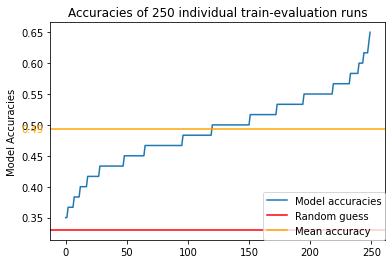

In [24]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

total = len(accuracies)
mean = sum(accuracies)/total

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sorted(accuracies), label='Model accuracies')
plt.axhline(y=0.33, color='r', linestyle='-', label='Random guess')
plt.axhline(y=mean, color='orange', linestyle='-', label='Mean accuracy')
ax.text(-0.02, mean, "{:.2f}".format(mean), color='orange', ha="right", va="center", 
        transform=ax.get_yaxis_transform())
plt.ylabel('Model Accuracies')
plt.title(f"Accuracies of {total} individual train-evaluation runs")
plt.legend(loc="lower right", borderaxespad=0)
plt.savefig(PATH_GDRIVE_TMP + 'plots/accuracies_bert_4.png')
plt.show()